In [1]:
# base
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

/home/saule/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/train.csv')
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
test = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


<BarContainer object of 1460 artists>

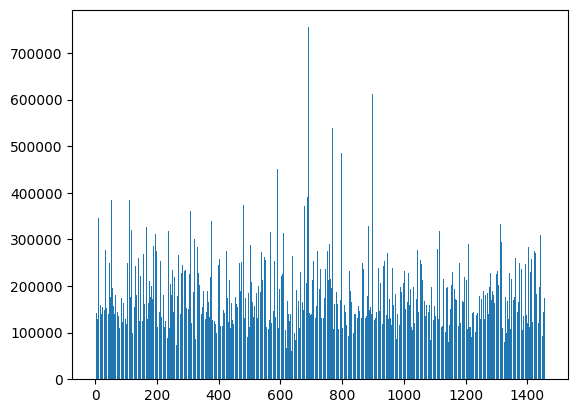

In [4]:
plt.bar(train.index, train['SalePrice'])

In [5]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
train_new = train[train['SalePrice'] <= 300000]
train_new['SalePrice'].describe()

count      1345.000000
mean     164246.190335
std       52094.670262
min       34900.000000
25%      128000.000000
50%      156000.000000
75%      196000.000000
max      299800.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

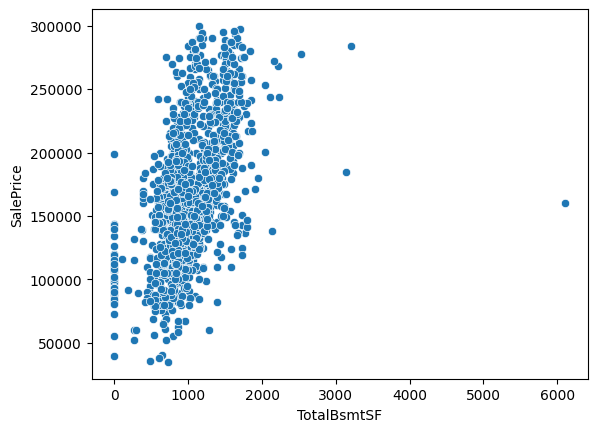

In [9]:
sns.scatterplot(data=train_new, x='TotalBsmtSF', y='SalePrice')

In [ ]:
train_new = train_new[train_new['TotalBsmtSF'] <= 2000]
train_new.info()            

(array([488.,   0.,   0., 906.,   0.,   0.,  52.,   0.,   0.,  14.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

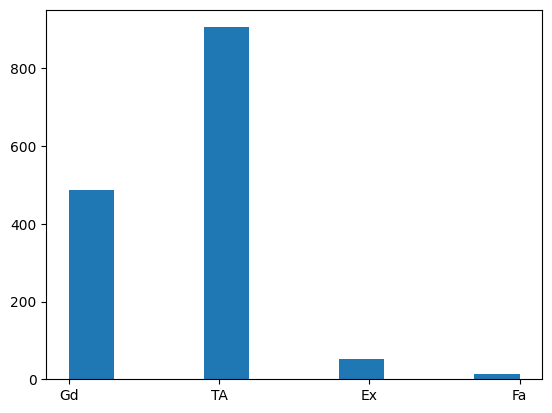

In [13]:
plt.hist(train['ExterQual'])

(array([419.,   0.,   0., 900.,   0.,   0.,  12.,   0.,   0.,  14.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

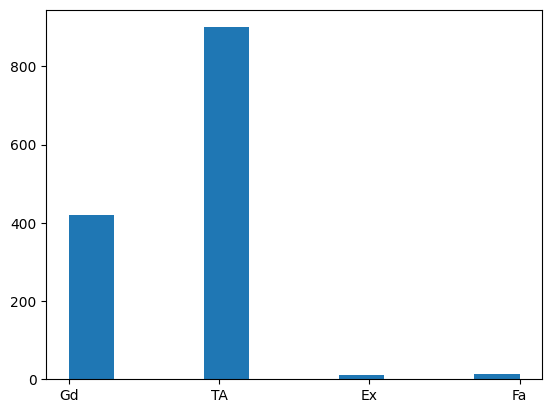

In [14]:
plt.hist(train_new['ExterQual'])

(array([1.175e+03, 0.000e+00, 1.390e+02, 0.000e+00, 0.000e+00, 2.800e+01,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

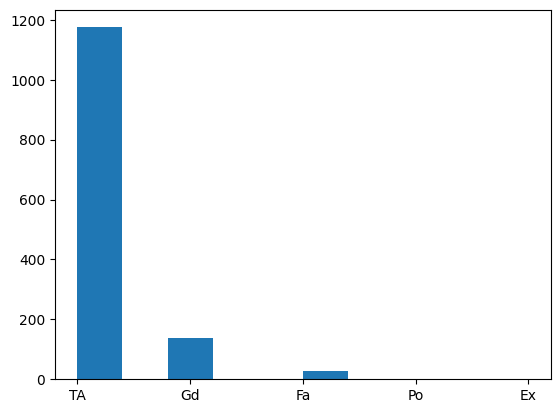

In [15]:
plt.hist(train_new['ExterCond'])

(array([544.,   0., 624.,   0., 144.,   0.,   3.,   0.,  24.,   6.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

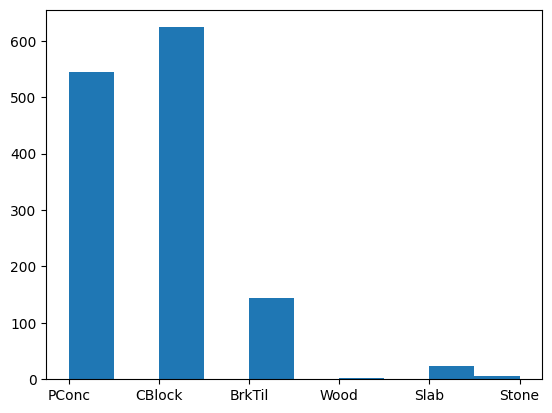

In [16]:
plt.hist(train_new['Foundation'])

(array([1.428e+03, 0.000e+00, 1.800e+01, 0.000e+00, 7.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

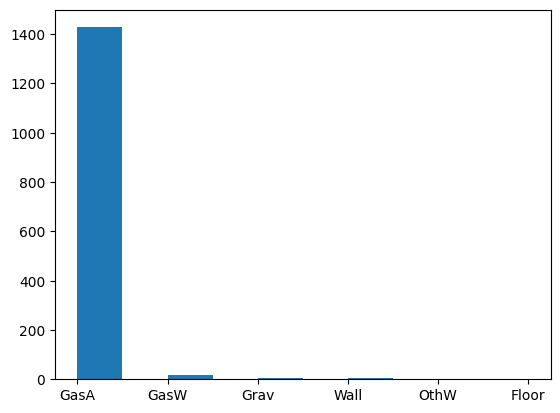

In [23]:
plt.hist(train['Heating'])  # дропнуть

(array([741.,   0., 241.,   0.,   0., 428.,   0.,  49.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

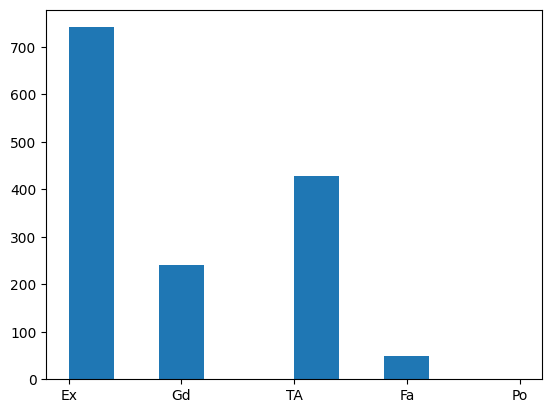

In [25]:
plt.hist(train['HeatingQC'])  

<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

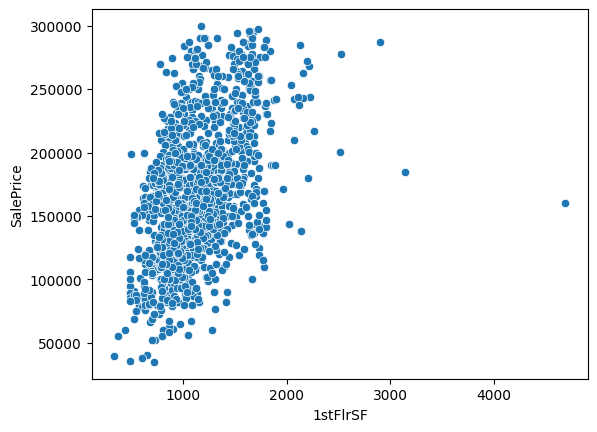

In [27]:
sns.scatterplot(data=train_new, x='1stFlrSF', y='SalePrice') # фильтрануть выбросы

<Axes: xlabel='2ndFlrSF', ylabel='SalePrice'>

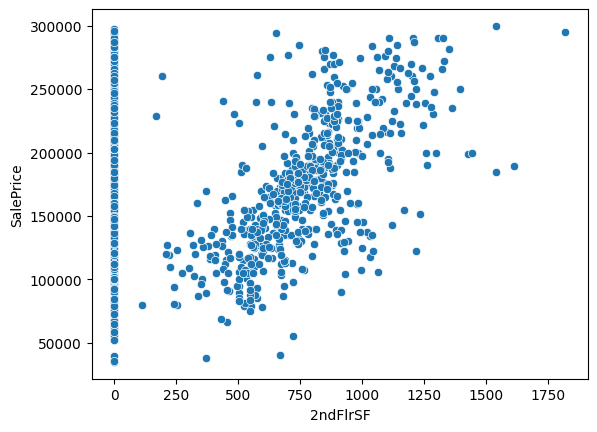

In [28]:
sns.scatterplot(data=train_new, x='2ndFlrSF', y='SalePrice') 

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

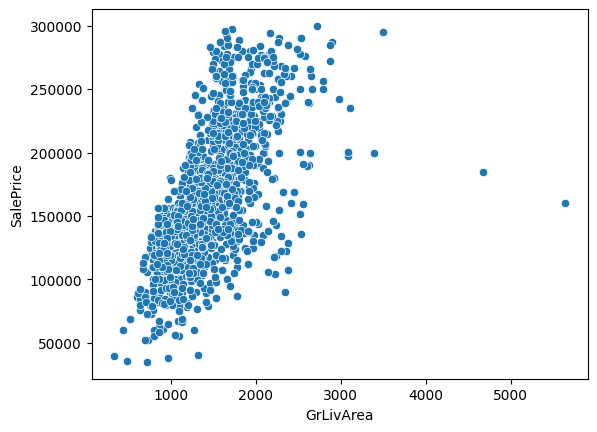

In [30]:
sns.scatterplot(data=train_new, x='GrLivArea', y='SalePrice')  

<Axes: xlabel='LowQualFinSF', ylabel='SalePrice'>

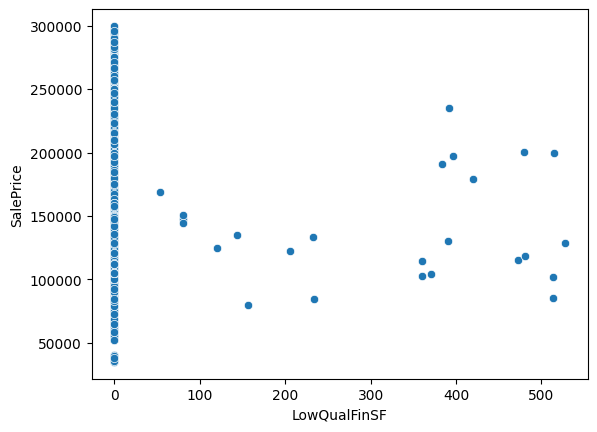

In [31]:
sns.scatterplot(data=train_new, x='LowQualFinSF', y='SalePrice') # дропнуть

(array([856.,   0.,   0., 588.,   0.,   0.,  15.,   0.,   0.,   1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

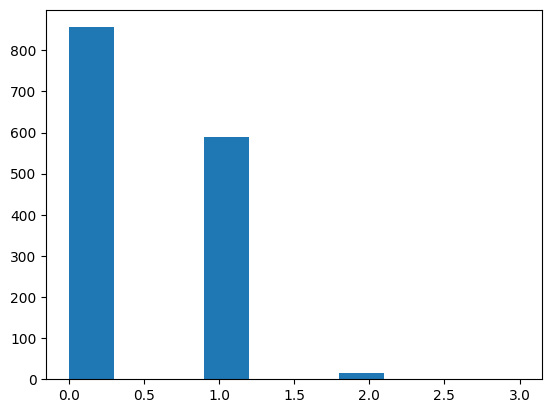

In [33]:
plt.hist(train['BsmtFullBath'])    # дропнуть

(array([1378.,    0.,    0.,    0.,    0.,   80.,    0.,    0.,    0.,
           2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

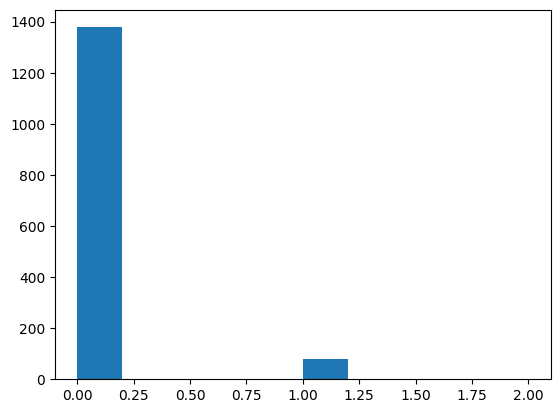

In [34]:
plt.hist(train['BsmtHalfBath'])    # дропнуть

(array([  9.,   0.,   0., 650.,   0.,   0., 768.,   0.,   0.,  33.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

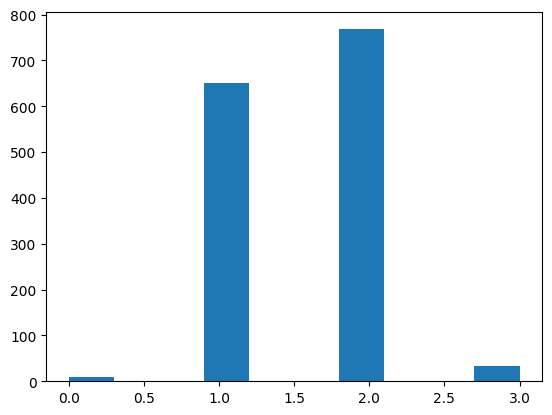

In [35]:
plt.hist(train['FullBath'])   

(array([913.,   0.,   0.,   0.,   0., 535.,   0.,   0.,   0.,  12.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

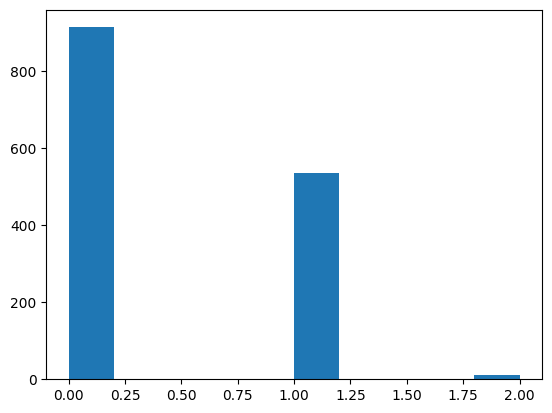

In [38]:
plt.hist(train['HalfBath'])    # дропнуть

(array([  6.,  50., 358., 804.,   0., 213.,  21.,   7.,   0.,   1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

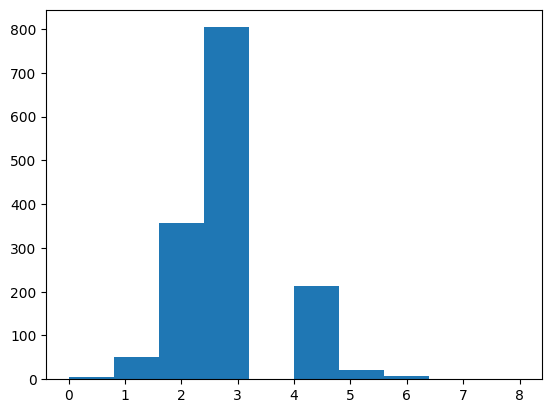

In [41]:
plt.hist(train['BedroomAbvGr'])

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.392e+03, 0.000e+00, 0.000e+00,
        6.500e+01, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

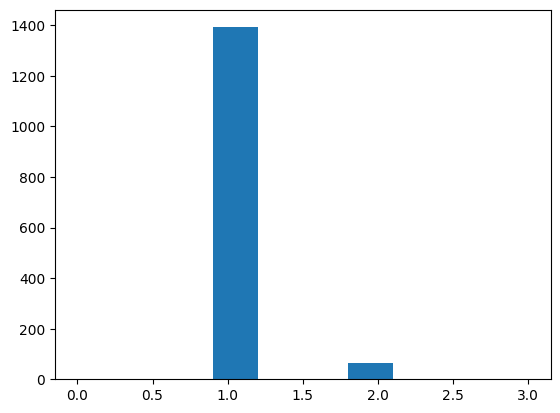

In [43]:
plt.hist(train['KitchenAbvGr']) # дропнуть

(array([1382.,    0.,    0.,    0.,    0.,   65.,    0.,    0.,    0.,
          13.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

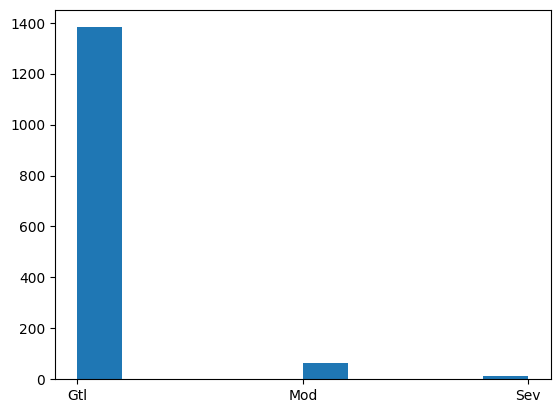

In [44]:
plt.hist(train['LandSlope']) 


(array([1.36e+03, 3.10e+01, 0.00e+00, 1.40e+01, 0.00e+00, 3.40e+01,
        1.50e+01, 0.00e+00, 5.00e+00, 1.00e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

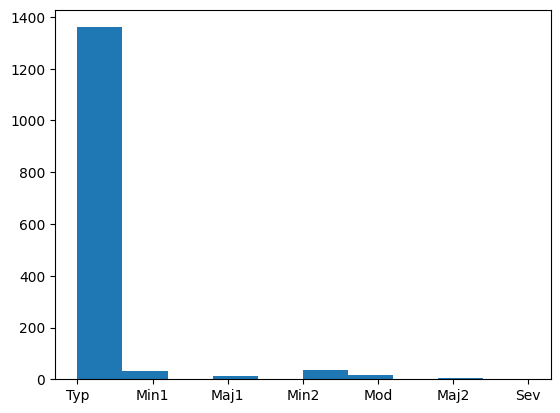

In [45]:
plt.hist(train['Functional']) 

(array([586.,   0.,   0., 735.,   0.,   0., 100.,   0.,   0.,  39.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

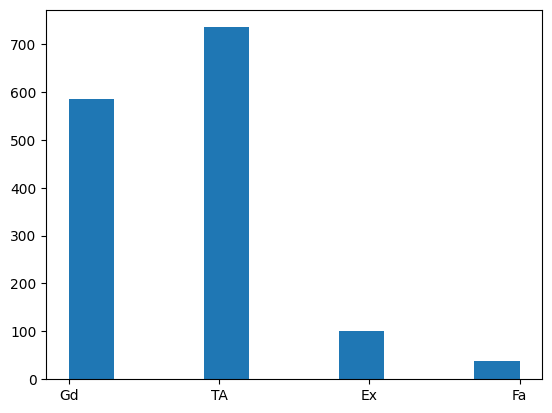

In [46]:
plt.hist(train['KitchenQual']) 

(array([1454.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           6.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

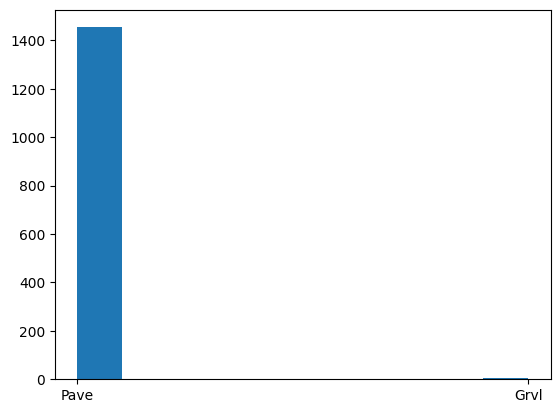

In [53]:
plt.hist(train['Street']) 

(array([690.,   0.,   0., 650.,   0.,   0., 115.,   0.,   0.,   5.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

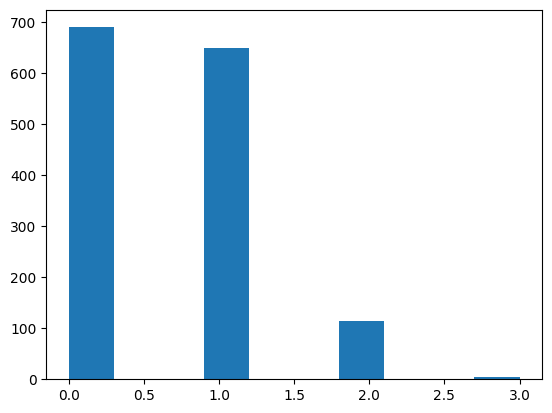

In [54]:
plt.hist(train['Fireplaces']) 

(array([1151.,    0.,  218.,    0.,    0.,   10.,    0.,   65.,    0.,
          16.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

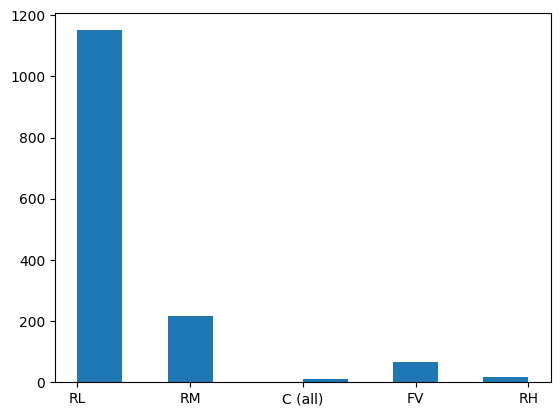

In [55]:
plt.hist(train['MSZoning']) 

In [ ]:
plt.hist(train['MSZoning']) 